---
#### Ref:
1. https://ai.googleblog.com/2015/06/inceptionism-going-deeper-into-neural.html
2. https://www.tensorflow.org/tutorials/generative/deepdream

In [1]:
import os
import time
import warnings
import PIL.Image
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as display

In [2]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras import layers, models, optimizers

In [3]:
print(tf.__version__)
warnings.filterwarnings('ignore')

2.4.0


---
#### Call Out GPU

In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Restrict TensorFlow to only use the fourth GPU
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')

        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


---
#### Parameters

In [5]:
IMG_PATH = 'img/hamster.jpg'
STEPS = 50
STEP_SIZE = 0.01
OCTAVE_SCALE = 1.30

---
#### Common Functions

In [6]:
# load image
def load_img(img_path):
    max_dim = 500
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    
    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim
    
    new_shape = tf.cast(shape * scale, tf.int32)
    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]
    return img[0].numpy()

# Normalize an image
def deprocess(img):
    img = img * 127.5 + 127.5
    return tf.cast(img, tf.uint8)

---
#### Load Images

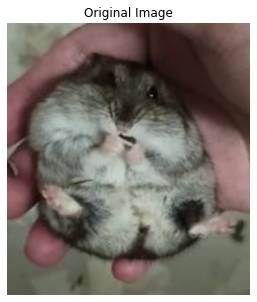

In [7]:
orig_image = load_img(IMG_PATH)
#preprocessing
orig_image = tf.cast(255 * orig_image, tf.uint8)
plt.figure(figsize=(5,5))
plt.imshow(orig_image)
plt.axis('off')
plt.title('Original Image')
plt.show()

---
#### Build Feature Extraction Model

In [8]:
base_model = keras.applications.InceptionV3(include_top=False, weights='imagenet')
# Maximize the activations of these layers
names = ['mixed3', 'mixed5']
layers = [base_model.get_layer(name).output for name in names]

# Create the feature extraction model
dream_model = tf.keras.Model(inputs=base_model.input, outputs=layers)

---
#### Define Loss
The loss is the sum of the activations in the chosen layers. The loss is normalized at each layer so the contribution from larger layers does not outweigh smaller layers. Normally, loss is a quantity you wish to minimize via gradient descent. In DeepDream, you will maximize this loss via gradient ascent.

In [9]:
def calc_loss(img, model):
    # Pass forward the image through the model to retrieve the activations.
    # Converts the image into a batch of size 1.
    img_batch = tf.expand_dims(img, axis=0)
    layer_activations = model(img_batch)
    
    if len(layer_activations) == 1:
        layer_activations = [layer_activations]
        
    losses = []
    for act in layer_activations:
        loss = tf.math.reduce_mean(act) #normalize
        losses.append(loss)
        
    return tf.reduce_sum(losses)

---
#### Gradient Ascent
Once you have calculated the loss for the chosen layers, all that is left is to calculate the gradients with respect to the image, and add them to the original image. 

Adding the gradients to the image enhances the patterns seen by the network. At each step, you will have created an image that increasingly excites the activations of certain layers in the network.

The method that does this, below, is wrapped in a `tf.function` for performance. It uses an `input_signature` to ensure that the function is not retraced for different image sizes or `steps`/`step_size` values. See the [Concrete functions guide](../../guide/function.ipynb) for details.

In [10]:
class DeepDream(tf.Module):
    def __init__(self, model):
        self.model = model
    
    @tf.function(
        input_signature=(
            tf.TensorSpec(shape=[None,None,3], dtype=tf.float32),
            tf.TensorSpec(shape=[], dtype=tf.int32),
            tf.TensorSpec(shape=[], dtype=tf.float32)
        )
    )
    def __call__(self, img, steps, step_size):
        print("Tracing")
        loss = tf.constant(0.0)
        for n in tf.range(steps):
            with tf.GradientTape() as tape:
                tape.watch(img)
                loss = calc_loss(img, self.model)
            
            # Calculate the gradient of the loss with respect to the pixels of the input image.
            gradients = tape.gradient(loss, img)
            
            # Normalize the gradients.
            gradients /= tf.math.reduce_std(gradients) + 1e-8 
            
            # In gradient ascent, the "loss" is maximized so that the input image increasingly "excites" the layers.
            # You can update the image by directly adding the gradients (because they're the same shape!)
            img = img + gradients * step_size
            img = tf.clip_by_value(img, -1, 1)
            
        return loss, img

In [11]:
deepdream = DeepDream(dream_model)

---
#### Dreaming Functions

In [12]:
def deep_dreaming_simple(img, steps=100, step_size=0.01):
    # Convert from uint8 to the range expected by the model.
    img = keras.applications.inception_v3.preprocess_input(tf.cast(img, tf.float32))
    img = tf.convert_to_tensor(img)
    step_size = tf.convert_to_tensor(step_size)
    
    steps_remaining, step = steps, 0
    while steps_remaining:
        run_steps = tf.constant(steps_remaining)
        if steps_remaining > 100:
            run_steps = tf.constant(100)
            
        steps_remaining -= run_steps
        step += run_steps
        
        loss, img = deepdream(img, run_steps, tf.constant(step_size))
        display.clear_output(wait=True)
        
        plt.figure(figsize=(5,5))
        plt.imshow(deprocess(img))
        plt.axis('off')
        plt.show()
        print ("Step {}, loss {}".format(step, loss))
        
    result = deprocess(img)
    display.clear_output(wait=True)
    plt.figure(figsize=(5,5))
    plt.imshow(result)
    plt.axis('off')
    plt.show()
    
    return result

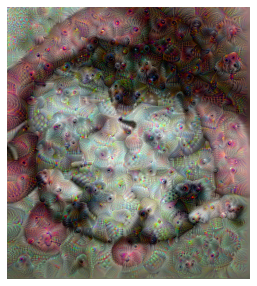

In [13]:
dream_img = deep_dreaming_simple(img=orig_image, steps=100, step_size=0.01)

---
#### Taking it up an octave
There are a few issues with this first attempt: 

  1. The output is noisy (this could be addressed with a `tf.image.total_variation` loss).
  1. The image is low resolution.
  1. The patterns appear like they're all happening at the same granularity.
  
One approach that addresses all these problems is applying gradient ascent at different scales. This will allow patterns generated at smaller scales to be incorporated into patterns at higher scales and filled in with additional detail.

To do this you can perform the previous gradient ascent approach, then increase the size of the image (which is referred to as an octave), and repeat this process for multiple octaves.

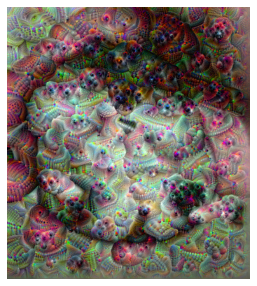

Time used: 6.7937 sec


In [14]:
start = time.time()
img = tf.constant(np.array(orig_image))
base_shape = tf.shape(img)[:-1]
float_base_shape = tf.cast(base_shape, tf.float32)

for n in range(-2, 3):
    new_shape = tf.cast(float_base_shape * (OCTAVE_SCALE**n), tf.int32)
    img = tf.image.resize(img, new_shape).numpy()
    img = deep_dreaming_simple(img=img, steps=STEPS, step_size=STEP_SIZE)
    
display.clear_output(wait=True)
img = tf.image.resize(img, base_shape)
img = tf.image.convert_image_dtype(img / 255.0, dtype=tf.uint8)

plt.figure(figsize=(5,5))
plt.imshow(img)
plt.axis('off')
plt.show()

end = time.time()
print("Time used: {:.4f} sec".format(end-start))

---
#### Scaling up with tiles
One thing to consider is that as the image increases in size, so will the time and memory necessary to perform the gradient calculation. The above octave implementation will not work on very large images, or many octaves.

To avoid this issue you can split the image into tiles and compute the gradient for each tile.

Applying random shifts to the image before each tiled computation prevents tile seams from appearing.

In [15]:
# random shift
def random_roll(img, maxroll):
    # Randomly shift the image to avoid tiled boundaries.
    shift = tf.random.uniform(shape=[2], minval=-maxroll, maxval=maxroll, dtype=tf.int32)
    img_rolled = tf.roll(img, shift=shift, axis=[0,1])
    return shift, img_rolled

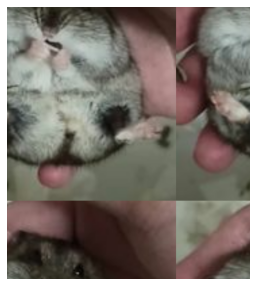

In [16]:
shift, img_rolled = random_roll(np.array(orig_image), 512)
plt.figure(figsize=(5,5))
plt.imshow(img_rolled)
plt.axis('off')
plt.show()

---
#### Gradient Ascent with Tiled

In [17]:
class TiledGradients(tf.Module):
    def __init__(self, model):
        self.model = model
        
    @tf.function(
        input_signature=(
            tf.TensorSpec(shape=[None,None,3], dtype=tf.float32),
            tf.TensorSpec(shape=[], dtype=tf.int32)
        )
    )
    def __call__(self, img, tile_size=512):
        shift, img_rolled = random_roll(img, tile_size)
        
        # Initialize the image gradients to zero.
        gradients = tf.zeros_like(img_rolled)
        
        # Skip the last tile, unless there's only one tile.
        xs = tf.range(0, img_rolled.shape[0], tile_size)[:-1]
        if not tf.cast(len(xs), bool):
            xs = tf.constant([0])
        ys = tf.range(0, img_rolled.shape[1], tile_size)[:-1]
        if not tf.cast(len(ys), bool):
            ys = tf.constant([0])
            
        for x in xs:
            for y in ys:
                with tf.GradientTape() as tape:
                    tape.watch(img_rolled)
                    # Extract a tile out of the image.
                    img_tile = img_rolled[x:x + tile_size, y:y + tile_size]
                    loss = calc_loss(img_tile, self.model)
                
                # Update the image gradients for this tile.
                gradients = gradients + tape.gradient(loss, img_rolled)
        
        # Undo the random shift applied to the image and its gradients.
        gradients = tf.roll(gradients, shift=-shift, axis=[0,1])
        # Normalize the gradients.
        gradients /= tf.math.reduce_std(gradients) + 1e-8 
        
        return gradients

In [18]:
get_tiled_gradients = TiledGradients(dream_model)

---
#### Dreaming Function with Tiled

In [19]:
def deep_dreaming_octaves(img, steps_per_octave=100, step_size=0.01, octaves=range(-2,3), octave_scale=1.3):
    base_shape = tf.shape(img)
    img = keras.preprocessing.image.img_to_array(img)
    img = keras.applications.inception_v3.preprocess_input(tf.cast(img, tf.float32))
    
    initial_shape = img.shape[:-1]
    img = tf.image.resize(img, initial_shape)
    for octave in octaves:
        # Scale the image based on the octave
        new_size = tf.cast(tf.convert_to_tensor(base_shape[:-1]), tf.float32)*(octave_scale**octave)
        img = tf.image.resize(img, tf.cast(new_size, tf.int32))
        
        for step in range(steps_per_octave):
            gradients = get_tiled_gradients(img)
            img = img + gradients * step_size
            img = tf.clip_by_value(img, -1, 1)
            
            if (step + 1) % 10 == 0 or (step + 1) == steps_per_octave:
                display.clear_output(wait=True)
                plt.figure(figsize=(5,5))
                plt.imshow(deprocess(img))
                plt.axis('off')
                plt.show()
                
                print ("Octave {}, Step {}".format(octave, step))
                
    result = deprocess(img)
    return result

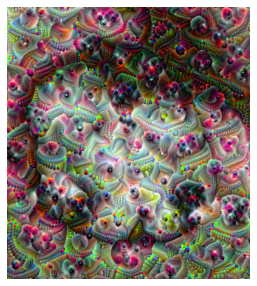

In [20]:
img = deep_dreaming_octaves(img=orig_image, step_size=STEP_SIZE)
display.clear_output(wait=True)
img = tf.image.resize(img, base_shape)
img = tf.image.convert_image_dtype(img / 255.0, dtype=tf.uint8)

plt.figure(figsize=(5,5))
plt.imshow(img)
plt.axis('off')
plt.show()